In [ ]:
# Ch 0.1.1: ParedDDIMScheduler

## Part 0: Setup

In [1]:
# Install diffusers
!pip install transformers diffusers accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 96.4 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 95.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 61.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 113.7 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.1/330.1 kB 68.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 98.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.0/169.0 kB 44.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2023.3.0
    Uninstalling fsspec-2023.3.0:
      Successfully uninstalled fsspec-2023.3.0
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.13.1
    Uninstalling huggingface-hub-0.13.1:
      Successfully uninstalled huggingface-hub-0.13.1
  Attempting uninstall: tokenizers
    Found existing installation: toke

tokenizer/tokenizer_config.json:   0%|          | 0.00/824 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/633 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:244: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddim.DDIMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)


scheduler/scheduler_config.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/909 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

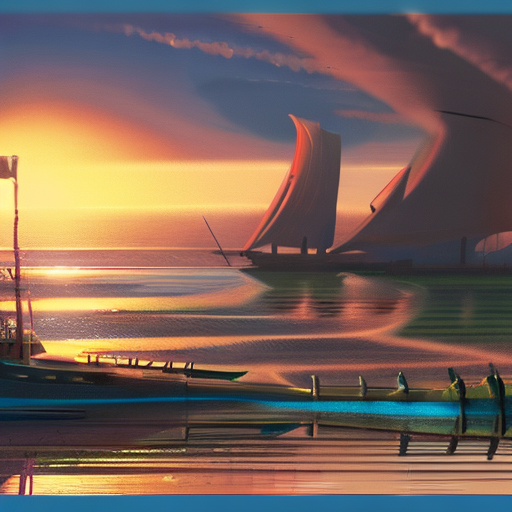

In [2]:
import torch
from torchvision.transforms import ToPILImage
from transformers import CLIPTokenizer, CLIPTextModel
from diffusers import DDIMScheduler, UNet2DConditionModel, AutoencoderKL

class PareDiffusionPipeline:
	def __init__(self, tokenizer, text_encoder, scheduler, unet, vae, device=torch.device("cuda"), dtype=torch.float16):
		"""
		Initialize the diffusion pipeline components.
		"""
		self.tokenizer = tokenizer
		self.text_encoder = text_encoder.to(device=device, dtype=dtype)
		self.scheduler = scheduler
		self.unet = unet.to(device=device, dtype=dtype)
		self.vae = vae.to(device=device, dtype=dtype)
		self.device = device
		self.dtype = dtype

	@classmethod
	def from_pretrained(cls, model_name, device=torch.device("cuda"), dtype=torch.float16):
		"""
		Load all necessary components from the pretrained model.

		Args:
			model_name (str): The name of the pretrained model.
			device (torch.device, optional): The device to use for the pipeline. Defaults to torch.device("cuda").
			dtype (torch.dtype, optional): The dtype to use for the pipeline. Defaults to torch.float16.
		
		Returns:
			PareDiffusionPipeline: The initialized pipeline.
		"""
		tokenizer = CLIPTokenizer.from_pretrained(model_name, subfolder="tokenizer")
		text_encoder = CLIPTextModel.from_pretrained(model_name, subfolder="text_encoder")
		scheduler = DDIMScheduler.from_config(model_name, subfolder="scheduler")
		unet = UNet2DConditionModel.from_pretrained(model_name, subfolder="unet")
		vae = AutoencoderKL.from_pretrained(model_name, subfolder="vae")
		return cls(tokenizer, text_encoder, scheduler, unet, vae, device, dtype)

	def encode_prompt(self, prompt: str):
		"""
		Encode the text prompt into embeddings using the text encoder.
		"""
		prompt_embeds = self.get_embes(prompt, self.tokenizer.model_max_length)
		negative_prompt_embeds = self.get_embes([''], prompt_embeds.shape[1])
		prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds])
		return prompt_embeds

	def get_embes(self, prompt, max_length):
		"""
		Encode the text prompt into embeddings using the text encoder.
		"""
		text_inputs = self.tokenizer(prompt, padding="max_length", max_length=max_length, truncation=True, return_tensors="pt")
		text_input_ids = text_inputs.input_ids.to(self.device)
		prompt_embeds = self.text_encoder(text_input_ids)[0].to(dtype=self.dtype, device=self.device)
		return prompt_embeds

	def get_latent(self, width: int, height: int):
		"""
		Generate a random initial latent tensor to start the diffusion process.
		"""
		return torch.randn((4, width // 8, height // 8)).to(
			device=self.device, dtype=self.dtype
		)

	def retrieve_timesteps(self, num_inference_steps=None):
		"""
		Retrieve the timesteps for the diffusion process from the scheduler.
		"""
		self.scheduler.set_timesteps(num_inference_steps, device=self.device)
		timesteps = self.scheduler.timesteps
		return timesteps, num_inference_steps

	@torch.no_grad()
	def denoise(self, latents, prompt_embeds, num_inference_steps=50, guidance_scale=7.5):
		"""
		Iteratively denoise the latent space using the diffusion model to produce an image.
		"""
		timesteps, num_inference_steps = self.retrieve_timesteps(num_inference_steps)
	
		for t in timesteps:
			latent_model_input = torch.cat([latents] * 2)
			
			# Predict the noise residual for the current timestep
			noise_residual = self.unet(latent_model_input, t, encoder_hidden_states=prompt_embeds)[0]
			uncond_residual, text_cond_residual = noise_residual.chunk(2)
			guided_noise_residual = uncond_residual + guidance_scale * (text_cond_residual - uncond_residual)

			# Update latents by reversing the diffusion process for the current timestep
			latents = self.scheduler.step(guided_noise_residual, t, latents)[0]

		return latents
	
	def denormalize(self, image):
		"""
		Denormalize the image tensor to the range [0, 255].
		"""
		return (image / 2 + 0.5).clamp(0, 1)

	def tensor_to_image(self, tensor):
		"""
		Convert a tensor to a PIL Image.
		"""
		return ToPILImage()(tensor.detach().cpu())

	@torch.no_grad()
	def vae_decode(self, latents):
		"""
		Decode the latent tensors using the VAE to produce an image.
		"""
		image = self.vae.decode(latents / self.vae.config.scaling_factor)[0][0]
		image = self.denormalize(image)
		image = self.tensor_to_image(image)
		return image

	def __call__(self, prompt: str, height: int = 512, width: int = 512, num_inference_steps: int = 50, guidance_scale: int = 7.5):
		"""
		Generate an image from a text prompt using the entire pipeline.

		Args:
			prompt (str): The text prompt to generate an image from.
			height (int, optional): The height of the generated image. Defaults to 512.
			width (int, optional): The width of the generated image. Defaults to 512.
			num_inference_steps (int, optional): The number of diffusion steps to perform. Defaults to 50.
			guidance_scale (int, optional): The scale of the guidance. Defaults to 7.5.
		
		Returns:
			PIL.Image: The generated image.
		"""
		prompt_embeds = self.encode_prompt(prompt)
		latents = self.get_latent(width, height).unsqueeze(dim=0)
		latents = self.denoise(latents, prompt_embeds, num_inference_steps, guidance_scale)
		image = self.vae_decode(latents)
		return image


device = torch.device("cuda")
dtype = torch.float16
model_name = "stabilityai/stable-diffusion-2"
width = 512
height = 512
num_inference_steps = 50

pipe = PareDiffusionPipeline.from_pretrained(model_name)

prompt = "painting depicting the sea, sunrise, ship, artstation, 4k, concept art"
image = pipe(prompt)
image.show()


## Part 2: Get values of Scheduler

In [9]:
scheduler = DDIMScheduler.from_config(model_name, subfolder="scheduler")
scheduler

/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:244: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddim.DDIMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)


DDIMScheduler {
  "_class_name": "DDIMScheduler",
  "_diffusers_version": "0.25.0",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "v_prediction",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 1,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null
}

In [10]:
scheduler.config

FrozenDict([('num_train_timesteps', 1000),
            ('beta_start', 0.00085),
            ('beta_end', 0.012),
            ('beta_schedule', 'scaled_linear'),
            ('trained_betas', None),
            ('clip_sample', False),
            ('set_alpha_to_one', False),
            ('steps_offset', 1),
            ('prediction_type', 'v_prediction'),
            ('thresholding', False),
            ('dynamic_thresholding_ratio', 0.995),
            ('clip_sample_range', 1.0),
            ('sample_max_value', 1.0),
            ('timestep_spacing', 'leading'),
            ('rescale_betas_zero_snr', False),
            ('_use_default_values',
             ['sample_max_value',
              'dynamic_thresholding_ratio',
              'timestep_spacing',
              'thresholding',
              'rescale_betas_zero_snr',
              'clip_sample_range']),
            ('_class_name', 'DDIMScheduler'),
            ('_diffusers_version', '0.25.0'),
            ('skip_prk_steps', True)]

In [11]:
scheduler.betas

tensor([0.0008, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009,
        0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009,
        0.0009, 0.0009, 0.0009, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0015, 

## Part 3: Check How Works The Scheduler.

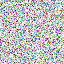

In [12]:
prompt_embeds = pipe.encode_prompt(prompt)
latents = pipe.get_latent(width, height).unsqueeze(dim=0)

display(pipe.tensor_to_image(latents[0]))

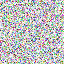

In [13]:
scheduler = DDIMScheduler.from_config(model_name, subfolder="scheduler")

guidance_scale = 7.5
timesteps, num_inference_steps = pipe.retrieve_timesteps(num_inference_steps)
t = timesteps[0]

latent_model_input = torch.cat([latents] * 2)

# Predict the noise residual for the current timestep
noise_residual = pipe.unet(latent_model_input, t, encoder_hidden_states=prompt_embeds)[0]
uncond_residual, text_cond_residual = noise_residual.chunk(2)
guided_noise_residual = uncond_residual + guidance_scale * (text_cond_residual - uncond_residual)

latents = pipe.scheduler.step(guided_noise_residual, t, latents)[0]
display(pipe.tensor_to_image(latents[0]))

In [6]:
import numpy as np
import torch

class ParedDDIMScheduler:
	def __init__(
		self,
		scheduler
	):
		self.config = scheduler.config

		self.betas = scheduler.betas
		self.alphas = 1.0 - self.betas
		self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
		self.final_alpha_cumprod = torch.tensor(1.0)

	def set_timesteps(self, num_inference_steps, device=None):
		self.num_inference_steps = num_inference_steps
		step_ratio = self.config.num_train_timesteps // self.num_inference_steps
		timesteps = (np.arange(0, num_inference_steps) * step_ratio).round()[::-1].copy().astype(np.int64)
		timesteps += self.config.steps_offset
		self.timesteps = torch.from_numpy(timesteps).to(device)

	def step(
		self,
		model_output: torch.FloatTensor,
		timestep: int,
		sample: torch.FloatTensor,
	):
		prev_timestep = timestep - self.config.num_train_timesteps // self.num_inference_steps

		alpha_prod_t = self.alphas_cumprod[timestep]
		alpha_prod_t_prev = self.alphas_cumprod[prev_timestep] if prev_timestep >= 0 else self.final_alpha_cumprod

		beta_prod_t = 1 - alpha_prod_t

		pred_original_sample = (alpha_prod_t**0.5) * sample - (beta_prod_t**0.5) * model_output
		pred_epsilon = (alpha_prod_t**0.5) * model_output + (beta_prod_t**0.5) * sample

		pred_sample_direction = (1 - alpha_prod_t_prev) ** (0.5) * pred_epsilon
		prev_sample = alpha_prod_t_prev ** (0.5) * pred_original_sample + pred_sample_direction

		return prev_sample, pred_original_sample

pared_scheduler = ParedDDIMScheduler(scheduler)

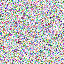

In [7]:
latents = pipe.get_latent(width, height).unsqueeze(dim=0)
latent_model_input = torch.cat([latents] * 2)

guidance_scale = 7.5
pared_scheduler.set_timesteps(num_inference_steps, device=device)
timesteps = pared_scheduler.timesteps
t = timesteps[0]

# Predict the noise residual for the current timestep
noise_residual = pipe.unet(latent_model_input, t, encoder_hidden_states=prompt_embeds)[0]
uncond_residual, text_cond_residual = noise_residual.chunk(2)
guided_noise_residual = uncond_residual + guidance_scale * (text_cond_residual - uncond_residual)

latents = pared_scheduler.step(guided_noise_residual, t, latents)[0]
display(pipe.tensor_to_image(latents[0]))

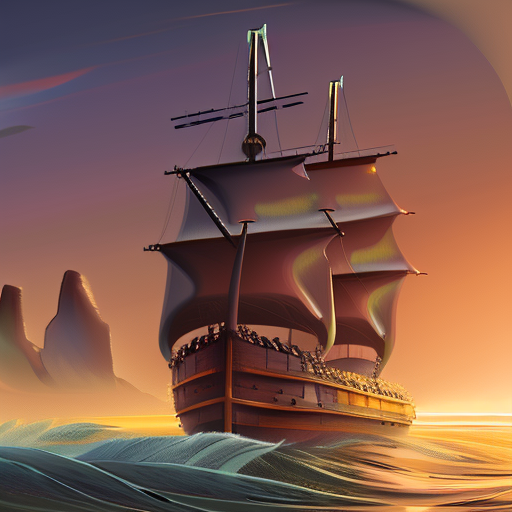

In [8]:
pipe.scheduler = pared_scheduler

prompt = "painting depicting the sea, sunrise, ship, artstation, 4k, concept art"
image = pipe(prompt)
image.show()

## Part 4: Display step of the Scheduler

In [19]:
timesteps = pared_scheduler.timesteps

latents = pipe.get_latent(width, height).unsqueeze(dim=0)
latent_model_input = torch.cat([latents] * 2)

# Predict the noise residual for the current timestep
noise_residual = pipe.unet(latent_model_input, t, encoder_hidden_states=prompt_embeds)[0]
uncond_residual, text_cond_residual = noise_residual.chunk(2)
guided_noise_residual = uncond_residual + guidance_scale * (text_cond_residual - uncond_residual)

# Define arguments for the scheduler.step() function
model_output = guided_noise_residual
timestep = timesteps[0]
sample = latents


In [20]:
prev_timestep = timestep - pared_scheduler.config.num_train_timesteps // pared_scheduler.num_inference_steps
prev_timestep

tensor(961, device='cuda:0')

In [21]:
alpha_prod_t = pared_scheduler.alphas_cumprod[timestep]
alpha_prod_t_prev = pared_scheduler.alphas_cumprod[prev_timestep] if prev_timestep >= 0 else pared_scheduler.final_alpha_cumprod
alpha_prod_t_prev

tensor(0.0073)

In [22]:
beta_prod_t = 1 - alpha_prod_t
pred_original_sample = (alpha_prod_t**0.5) * sample - (beta_prod_t**0.5) * model_output
pred_original_sample

tensor([[[[-1.0654, -0.0653,  0.6543,  ...,  0.1971,  0.0587, -0.6733],
          [-0.6323,  0.5342,  1.0039,  ...,  0.7998,  0.7749,  0.0688],
          [-0.7983,  0.4160,  0.9097,  ...,  0.8555,  0.7690, -0.1388],
          ...,
          [-4.3008, -2.0625, -2.2031,  ..., -2.1914, -1.9648, -2.0410],
          [-4.8047, -2.6719, -2.6094,  ..., -2.1289, -2.8750, -2.0605],
          [-5.4336, -4.8086, -4.4062,  ..., -4.1836, -4.1797, -4.8711]],

         [[-3.3496, -2.3086, -1.7041,  ..., -1.4961, -2.0879, -1.9922],
          [-2.1133, -0.5093,  0.0366,  ...,  0.5039, -0.0803, -0.7935],
          [-1.6064, -0.3933,  0.4268,  ...,  0.6826, -0.2671, -0.9043],
          ...,
          [-4.0859, -2.7109, -2.3633,  ..., -1.8018, -2.0703, -2.7266],
          [-4.0078, -2.8164, -2.4199,  ..., -1.8584, -2.2852, -3.1113],
          [-4.6484, -3.9023, -3.3535,  ..., -2.5703, -3.0566, -4.2031]],

         [[-0.4897,  0.0238, -0.2455,  ..., -0.5020, -0.4971,  0.3994],
          [-0.2974,  0.1918, -

In [23]:
pred_epsilon = (alpha_prod_t**0.5) * model_output + (beta_prod_t**0.5) * sample
pred_epsilon

tensor([[[[ 1.5000,  0.9141, -1.2266,  ..., -0.3760,  0.0978,  0.1080],
          [-0.1682, -0.2529, -1.9180,  ...,  0.2386, -0.6353, -0.6304],
          [ 1.4678,  0.3894, -1.1963,  ..., -0.1567,  0.7246, -0.6357],
          ...,
          [ 0.7881, -0.5566, -1.4707,  ...,  0.4990, -1.5469, -1.2988],
          [ 0.6782,  0.1718,  0.2603,  ...,  0.6035, -0.9341, -0.4683],
          [-1.1748,  0.5127,  1.3555,  ..., -0.4727,  0.6328,  2.0801]],

         [[ 0.4521,  0.4956, -0.2512,  ...,  0.7139,  2.5059,  1.6270],
          [ 2.0586,  0.3115,  1.1035,  ..., -1.0635, -0.6265, -0.8623],
          [ 0.0936,  0.1755, -1.8633,  ..., -1.7041,  0.5625,  1.5801],
          ...,
          [ 2.5176,  1.1123, -1.0244,  ..., -0.0240, -0.5796, -0.6562],
          [ 0.4648, -0.3940, -0.3120,  ...,  1.9385, -1.2959, -1.7803],
          [-0.8730,  1.9062, -0.6670,  ..., -2.4102,  0.7993,  1.2080]],

         [[ 0.9912,  0.2163, -1.4814,  ...,  1.2100,  0.8184, -0.4509],
          [-0.8145, -1.7686,  

In [24]:
pred_sample_direction = (1 - alpha_prod_t_prev) ** (0.5) * pred_epsilon
pred_sample_direction

tensor([[[[ 1.4941,  0.9106, -1.2217,  ..., -0.3745,  0.0975,  0.1077],
          [-0.1676, -0.2520, -1.9111,  ...,  0.2378, -0.6328, -0.6279],
          [ 1.4629,  0.3879, -1.1924,  ..., -0.1561,  0.7222, -0.6333],
          ...,
          [ 0.7852, -0.5547, -1.4658,  ...,  0.4973, -1.5410, -1.2939],
          [ 0.6758,  0.1711,  0.2593,  ...,  0.6011, -0.9307, -0.4666],
          [-1.1709,  0.5107,  1.3506,  ..., -0.4709,  0.6304,  2.0723]],

         [[ 0.4504,  0.4939, -0.2502,  ...,  0.7114,  2.4961,  1.6211],
          [ 2.0508,  0.3103,  1.0996,  ..., -1.0596, -0.6240, -0.8594],
          [ 0.0932,  0.1749, -1.8564,  ..., -1.6982,  0.5605,  1.5742],
          ...,
          [ 2.5078,  1.1084, -1.0205,  ..., -0.0240, -0.5776, -0.6538],
          [ 0.4631, -0.3926, -0.3108,  ...,  1.9316, -1.2910, -1.7734],
          [-0.8696,  1.8994, -0.6646,  ..., -2.4004,  0.7964,  1.2031]],

         [[ 0.9878,  0.2156, -1.4756,  ...,  1.2051,  0.8154, -0.4492],
          [-0.8115, -1.7617,  

In [25]:
prev_sample = alpha_prod_t_prev ** (0.5) * pred_original_sample + pred_sample_direction
prev_sample

tensor([[[[ 1.4033,  0.9053, -1.1660,  ..., -0.3577,  0.1025,  0.0502],
          [-0.2216, -0.2063, -1.8252,  ...,  0.3062, -0.5669, -0.6221],
          [ 1.3945,  0.4233, -1.1152,  ..., -0.0831,  0.7876, -0.6450],
          ...,
          [ 0.4182, -0.7305, -1.6543,  ...,  0.3103, -1.7090, -1.4678],
          [ 0.2659, -0.0569,  0.0366,  ...,  0.4194, -1.1758, -0.6426],
          [-1.6348,  0.1003,  0.9746,  ..., -0.8281,  0.2737,  1.6562]],

         [[ 0.1646,  0.2969, -0.3955,  ...,  0.5840,  2.3184,  1.4512],
          [ 1.8701,  0.2668,  1.1025,  ..., -1.0166, -0.6309, -0.9272],
          [-0.0439,  0.1414, -1.8203,  ..., -1.6396,  0.5376,  1.4971],
          ...,
          [ 2.1602,  0.8770, -1.2227,  ..., -0.1777, -0.7544, -0.8867],
          [ 0.1211, -0.6328, -0.5176,  ...,  1.7734, -1.4863, -2.0391],
          [-1.2666,  1.5664, -0.9507,  ..., -2.6191,  0.5356,  0.8447]],

         [[ 0.9458,  0.2177, -1.4961,  ...,  1.1621,  0.7729, -0.4150],
          [-0.8369, -1.7451,  

## Part 5: from_config

In [28]:
from huggingface_hub import hf_hub_download

config_file = hf_hub_download(
	model_name,
	filename="scheduler_config.json",
	subfolder="scheduler"
)
config_file

'/root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2/snapshots/1e128c8891e52218b74cde8f26dbfc701cb99d79/scheduler/scheduler_config.json'

In [29]:
import json

with open(config_file, "r", encoding="utf-8") as reader:
	text = reader.read()
config_dict = json.loads(text)
config_dict

{'_class_name': 'DDIMScheduler',
 '_diffusers_version': '0.8.0',
 'beta_end': 0.012,
 'beta_schedule': 'scaled_linear',
 'beta_start': 0.00085,
 'clip_sample': False,
 'num_train_timesteps': 1000,
 'prediction_type': 'v_prediction',
 'set_alpha_to_one': False,
 'skip_prk_steps': True,
 'steps_offset': 1,
 'trained_betas': None}

In [41]:
import json
import numpy as np
import torch

class ConfigClass:
	def __init__(self, **kwargs):
		"""Initialize scheduler with configuration dictionary."""
		for key, value in kwargs.items():
			setattr(self, key, value)

class ParedDDIMScheduler:
	def __init__(
		self,
		config_dict: dict
	):
		"""Initialize beta and alpha values for the scheduler."""
		self.config = ConfigClass(**config_dict)
		self.betas =  torch.linspace(self.config.beta_start**0.5, self.config.beta_end**0.5, self.config.num_train_timesteps, dtype=torch.float32) ** 2
		self.alphas = 1.0 - self.betas
		self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
		self.final_alpha_cumprod = torch.tensor(1.0)
	
	@classmethod
	def from_config(cls, model_name: str, subfolder: str = "scheduler", filename: str = "scheduler_config.json") -> "ParedDDIMScheduler":
		"""Create scheduler instance from configuration file."""
		config_file = hf_hub_download(
			model_name,
			filename=filename,
			subfolder=subfolder
		)
		with open(config_file, "r", encoding="utf-8") as reader:
			text = reader.read()
		config_dict = json.loads(text)
		return cls(config_dict)

	def set_timesteps(self, num_inference_steps: int, device: torch.device = None) -> None:
		"""Set the timesteps for the scheduler based on the number of inference steps."""
		self.num_inference_steps = num_inference_steps
		step_ratio = self.config.num_train_timesteps // self.num_inference_steps
		timesteps = (np.arange(0, num_inference_steps) * step_ratio).round()[::-1].copy().astype(np.int64)
		timesteps += self.config.steps_offset
		self.timesteps = torch.from_numpy(timesteps).to(device)

	def step(
		self,
		model_output: torch.FloatTensor,
		timestep: int,
		sample: torch.FloatTensor,
	) -> list:
		"""Perform a single step of denoising in the diffusion process."""
		prev_timestep = timestep - self.config.num_train_timesteps // self.num_inference_steps

		alpha_prod_t = self.alphas_cumprod[timestep]
		alpha_prod_t_prev = self.alphas_cumprod[prev_timestep] if prev_timestep >= 0 else self.final_alpha_cumprod

		beta_prod_t = 1 - alpha_prod_t
		pred_original_sample = (alpha_prod_t**0.5) * sample - (beta_prod_t**0.5) * model_output
		pred_epsilon = (alpha_prod_t**0.5) * model_output + (beta_prod_t**0.5) * sample

		pred_sample_direction = (1 - alpha_prod_t_prev) ** (0.5) * pred_epsilon
		prev_sample = alpha_prod_t_prev ** (0.5) * pred_original_sample + pred_sample_direction

		return prev_sample, pred_original_sample

pared_scheduler = ParedDDIMScheduler.from_config(model_name)

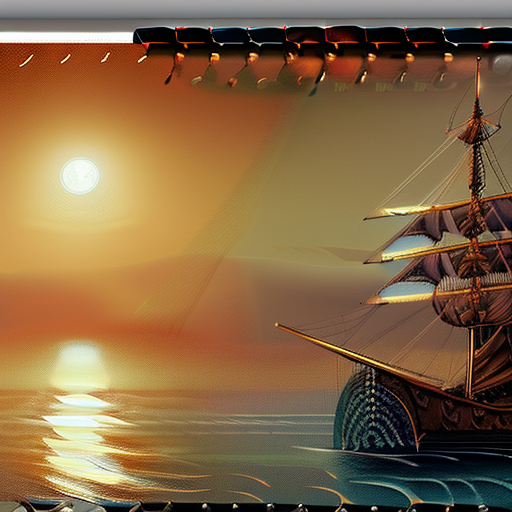

In [42]:
import torch
from torchvision.transforms import ToPILImage
from transformers import CLIPTokenizer, CLIPTextModel
from diffusers import UNet2DConditionModel, AutoencoderKL
#from .scheduler import ParedDDIMScheduler

class PareDiffusionPipeline:
	def __init__(self, tokenizer, text_encoder, scheduler, unet, vae, device=torch.device("cuda"), dtype=torch.float16):
		"""
		Initialize the diffusion pipeline components.
		"""
		self.tokenizer = tokenizer
		self.text_encoder = text_encoder.to(device=device, dtype=dtype)
		self.scheduler = scheduler
		self.unet = unet.to(device=device, dtype=dtype)
		self.vae = vae.to(device=device, dtype=dtype)
		self.device = device
		self.dtype = dtype

	@classmethod
	def from_pretrained(cls, model_name, device=torch.device("cuda"), dtype=torch.float16):
		"""
		Load all necessary components from the pretrained model.

		Args:
			model_name (str): The name of the pretrained model.
			device (torch.device, optional): The device to use for the pipeline. Defaults to torch.device("cuda").
			dtype (torch.dtype, optional): The dtype to use for the pipeline. Defaults to torch.float16.
		
		Returns:
			PareDiffusionPipeline: The initialized pipeline.
		"""
		tokenizer = CLIPTokenizer.from_pretrained(model_name, subfolder="tokenizer")
		text_encoder = CLIPTextModel.from_pretrained(model_name, subfolder="text_encoder")
		scheduler = ParedDDIMScheduler.from_config(model_name, subfolder="scheduler")
		unet = UNet2DConditionModel.from_pretrained(model_name, subfolder="unet")
		vae = AutoencoderKL.from_pretrained(model_name, subfolder="vae")
		return cls(tokenizer, text_encoder, scheduler, unet, vae, device, dtype)

	def encode_prompt(self, prompt: str):
		"""
		Encode the text prompt into embeddings using the text encoder.
		"""
		prompt_embeds = self.get_embes(prompt, self.tokenizer.model_max_length)
		negative_prompt_embeds = self.get_embes([''], prompt_embeds.shape[1])
		prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds])
		return prompt_embeds

	def get_embes(self, prompt, max_length):
		"""
		Encode the text prompt into embeddings using the text encoder.
		"""
		text_inputs = self.tokenizer(prompt, padding="max_length", max_length=max_length, truncation=True, return_tensors="pt")
		text_input_ids = text_inputs.input_ids.to(self.device)
		prompt_embeds = self.text_encoder(text_input_ids)[0].to(dtype=self.dtype, device=self.device)
		return prompt_embeds

	def get_latent(self, width: int, height: int):
		"""
		Generate a random initial latent tensor to start the diffusion process.
		"""
		return torch.randn((4, width // 8, height // 8)).to(
			device=self.device, dtype=self.dtype
		)

	def retrieve_timesteps(self, num_inference_steps=None):
		"""
		Retrieve the timesteps for the diffusion process from the scheduler.
		"""
		self.scheduler.set_timesteps(num_inference_steps, device=self.device)
		timesteps = self.scheduler.timesteps
		return timesteps, num_inference_steps

	@torch.no_grad()
	def denoise(self, latents, prompt_embeds, num_inference_steps=50, guidance_scale=7.5):
		"""
		Iteratively denoise the latent space using the diffusion model to produce an image.
		"""
		timesteps, num_inference_steps = self.retrieve_timesteps(num_inference_steps)
	
		for t in timesteps:
			latent_model_input = torch.cat([latents] * 2)
			
			# Predict the noise residual for the current timestep
			noise_residual = self.unet(latent_model_input, t, encoder_hidden_states=prompt_embeds)[0]
			uncond_residual, text_cond_residual = noise_residual.chunk(2)
			guided_noise_residual = uncond_residual + guidance_scale * (text_cond_residual - uncond_residual)

			# Update latents by reversing the diffusion process for the current timestep
			latents = self.scheduler.step(guided_noise_residual, t, latents)[0]

		return latents
	
	def denormalize(self, image):
		"""
		Denormalize the image tensor to the range [0, 255].
		"""
		return (image / 2 + 0.5).clamp(0, 1)

	def tensor_to_image(self, tensor):
		"""
		Convert a tensor to a PIL Image.
		"""
		return ToPILImage()(tensor.detach().cpu())

	@torch.no_grad()
	def vae_decode(self, latents):
		"""
		Decode the latent tensors using the VAE to produce an image.
		"""
		image = self.vae.decode(latents / self.vae.config.scaling_factor)[0][0]
		image = self.denormalize(image)
		image = self.tensor_to_image(image)
		return image

	def __call__(self, prompt: str, height: int = 512, width: int = 512, num_inference_steps: int = 50, guidance_scale: int = 7.5):
		"""
		Generate an image from a text prompt using the entire pipeline.

		Args:
			prompt (str): The text prompt to generate an image from.
			height (int, optional): The height of the generated image. Defaults to 512.
			width (int, optional): The width of the generated image. Defaults to 512.
			num_inference_steps (int, optional): The number of diffusion steps to perform. Defaults to 50.
			guidance_scale (int, optional): The scale of the guidance. Defaults to 7.5.
		
		Returns:
			PIL.Image: The generated image.
		"""
		prompt_embeds = self.encode_prompt(prompt)
		latents = self.get_latent(width, height).unsqueeze(dim=0)
		latents = self.denoise(latents, prompt_embeds, num_inference_steps, guidance_scale)
		image = self.vae_decode(latents)
		return image


model_name = "stabilityai/stable-diffusion-2"
pipe = PareDiffusionPipeline.from_pretrained(model_name)

prompt = "painting depicting the sea, sunrise, ship, artstation, 4k, concept art"
image = pipe(prompt)
image.show()
